# Importing all Relevant Libs & Data

In [4]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing, metrics
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from statsmodels.tsa.arima_model import ARIMA
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [13]:
# Reading the Data
train_df = pd.read_csv("train.csv", parse_dates=['timestamp'])
test_df = pd.read_csv("test.csv", parse_dates=['timestamp'])
train_df

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

# Feature Engineering

## Capping the outliers for price variable

In [14]:
ulimit = np.percentile(train_df.price_doc.values, 99)
llimit = np.percentile(train_df.price_doc.values, 1)
train_df['price_doc'].loc[train_df['price_doc']>ulimit] = ulimit
train_df['price_doc'].loc[train_df['price_doc']<llimit] = llimit

## Converting Categorical Variables into numerical variables by label encoding

In [15]:
for f in train_df.columns:
    if train_df[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values.astype('str')) + list(test_df[f].values.astype('str')))
        train_df[f] = lbl.transform(list(train_df[f].values.astype('str')))
        test_df[f] = lbl.transform(list(test_df[f].values.astype('str')))

product_type
sub_area
culture_objects_top_25
thermal_power_plant_raion
incineration_raion
oil_chemistry_raion
radiation_raion
railroad_terminal_raion
big_market_raion
nuclear_reactor_raion
detention_facility_raion
water_1line
big_road1_1line
railroad_1line
ecology


##Handling Null Values

In [16]:
#columns with null values;
col_with_nan = [col for col in train_df.columns if train_df[col].isnull().sum() > 0]
train_df[col_with_nan].isnull().sum().sort_values(ascending=False)

hospital_beds_raion                      14441
build_year                               13605
state                                    13559
cafe_sum_500_min_price_avg               13281
cafe_sum_500_max_price_avg               13281
cafe_avg_price_500                       13281
max_floor                                 9572
material                                  9572
num_room                                  9572
kitch_sq                                  9572
preschool_quota                           6688
school_quota                              6685
cafe_sum_1000_max_price_avg               6524
cafe_sum_1000_min_price_avg               6524
cafe_avg_price_1000                       6524
life_sq                                   6383
build_count_before_1920                   4991
build_count_block                         4991
raion_build_count_with_material_info      4991
build_count_wood                          4991
build_count_frame                         4991
build_count_b

We can remove all the features having nan values more than 4000 but we saw in EDA build_year,max_floor,num_room,life_sq are important features so we will keep them.

In [17]:
col_with_nan_4000 = col_with_nan = [col for col in train_df.columns if train_df[col].isnull().sum() > 4000]
droped_col = [col for col in col_with_nan_4000 if col not in ['num_room','build_year','max_floor','life_sq']]
train_df.drop(
    columns  = droped_col, inplace = True
)
test_df.drop(
    columns  = droped_col, inplace = True
)

In [18]:
col_with_nan = [col for col in train_df.columns if train_df[col].isna().sum() > 0]
train_df[col_with_nan].isnull().sum().sort_values(ascending=False)

build_year                     13605
num_room                        9572
max_floor                       9572
life_sq                         6383
cafe_avg_price_2000             1725
cafe_sum_2000_max_price_avg     1725
cafe_sum_2000_min_price_avg     1725
cafe_avg_price_3000              991
cafe_sum_3000_max_price_avg      991
cafe_sum_3000_min_price_avg      991
cafe_avg_price_5000              297
cafe_sum_5000_max_price_avg      297
cafe_sum_5000_min_price_avg      297
prom_part_5000                   178
floor                            167
railroad_station_walk_min         25
railroad_station_walk_km          25
metro_km_walk                     25
metro_min_walk                    25
ID_railroad_station_walk          25
dtype: int64

In [19]:
train_df.fillna(train_df.median(), inplace=True)
test_df.fillna(test_df.median(), inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


## Creating some additional features from timestamp variable

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  from ipykernel import kernelapp as app


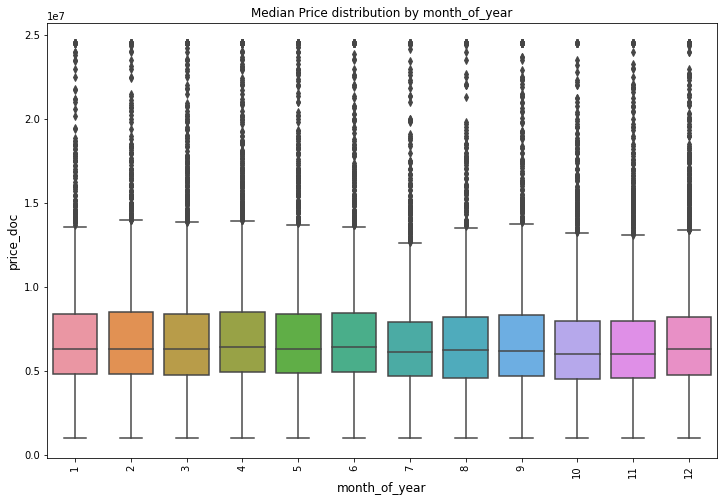

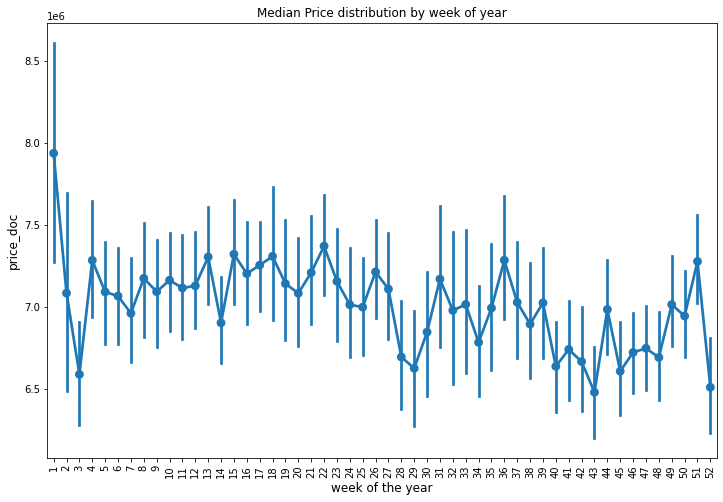

In [20]:
# year and month #
train_df["yearmonth"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.month
test_df["yearmonth"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.month
# year and week #
train_df["yearweek"] = train_df["timestamp"].dt.year*100 + train_df["timestamp"].dt.weekofyear
test_df["yearweek"] = test_df["timestamp"].dt.year*100 + test_df["timestamp"].dt.weekofyear
# year #
train_df["year"] = train_df["timestamp"].dt.year
test_df["year"] = test_df["timestamp"].dt.year
# month of year #
train_df["month_of_year"] = train_df["timestamp"].dt.month
test_df["month_of_year"] = test_df["timestamp"].dt.month
# week of year #
train_df["week_of_year"] = train_df["timestamp"].dt.weekofyear
test_df["week_of_year"] = test_df["timestamp"].dt.weekofyear
# day of week #
train_df["day_of_week"] = train_df["timestamp"].dt.weekday
test_df["day_of_week"] = test_df["timestamp"].dt.weekday

plt.figure(figsize=(12,8))
sns.boxplot(x='month_of_year', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('month_of_year', fontsize=12)
plt.title('Median Price distribution by month_of_year')
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.pointplot(x='week_of_year', y='price_doc', data=train_df)
plt.ylabel('price_doc', fontsize=12)
plt.xlabel('week of the year', fontsize=12)
plt.title('Median Price distribution by week of year')
plt.xticks(rotation='vertical')
plt.show()


## Creating Some more Additional Features 

In [21]:
# ratio of living area to full area #
train_df["ratio_life_sq_full_sq"] = train_df["life_sq"] / np.maximum(train_df["full_sq"].astype("float"),1)
train_df["ratio_life_sq_full_sq"].loc[train_df["ratio_life_sq_full_sq"]<0] = 0
train_df["ratio_life_sq_full_sq"].loc[train_df["ratio_life_sq_full_sq"]>1] = 1
test_df["ratio_life_sq_full_sq"] = test_df["life_sq"] / np.maximum(test_df["full_sq"].astype("float"),1)
test_df["ratio_life_sq_full_sq"].loc[test_df["ratio_life_sq_full_sq"]<0] = 0
test_df["ratio_life_sq_full_sq"].loc[test_df["ratio_life_sq_full_sq"]>1] = 1

# floor of the house to the total number of floors in the house, adding 1 to denominator as max_floor can also be 0 #
train_df["ratio_floor_max_floor"] = train_df["floor"] / (train_df["max_floor"].astype("float")+1)
test_df["ratio_floor_max_floor"] = test_df["floor"] / (test_df["max_floor"].astype("float")+1)

# num of floor from top #
train_df["floor_from_top"] = train_df["max_floor"] - train_df["floor"]
test_df["floor_from_top"] = test_df["max_floor"] - test_df["floor"]

# Difference of Full Area and living Area
train_df["extra_sq"] = train_df["full_sq"] - train_df["life_sq"]
test_df["extra_sq"] = test_df["full_sq"] - test_df["life_sq"]

# Age of Building
train_df["age_of_building"] = train_df["build_year"] - train_df["year"]
test_df["age_of_building"] = test_df["build_year"] - test_df["year"]


# Splitting the Data

In [22]:
X = train_df.drop(["id","timestamp", "price_doc"], axis=1)
test_X = test_df.drop(["id", "timestamp"] , axis=1)
y = (train_df.price_doc.values)
#Since our metric is "RMSLE" also, let us use log of the target variable also.
y_log = np.log1p(train_df.price_doc.values)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)
_, _, y_log_train, y_log_test = model_selection.train_test_split(X, y_log, test_size=0.2, random_state=42)
print("X_train : ",X_train.shape)
print("X_test : ",X_test.shape)
print("y_train : ",y_train.shape)
print("y_test : ",y_test.shape)

X_train :  (24376, 269)
X_test :  (6095, 269)
y_train :  (24376,)
y_test :  (6095,)


# Applying Models

## Fitting Linear Regression

In [23]:
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X_train,y_train)
y_pred = lin_reg.predict(X_test)
print("R square : ", lin_reg.score(X_test,y_test))
print("MSE : ",metrics.mean_squared_error(y_test,y_pred))

R square :  0.5043075650849353
MSE :  7542757301389.191


FOR RMSLE , using y_log target

In [24]:
lin_reg_log = LinearRegression(fit_intercept=True)
lin_reg_log.fit(X_train,y_log_train)
y_log_pred = lin_reg_log.predict(X_test)
lin_reg_log_rmsle = np.sqrt(metrics.mean_squared_log_error(y_log_test, y_log_pred))
print("RMSLE : ",lin_reg_log_rmsle)

RMSLE :  0.030192407001861665


## Applying Random Forest Regressor

In [25]:
rfr = RandomForestRegressor(n_estimators=200, min_samples_leaf=50, n_jobs=-1)
rfr.fit(X_train,y_train)
y_pred = rfr.predict(X_test)
print("R square : ", rfr.score(X_test,y_test))
print("MSE : ",metrics.mean_squared_error(y_test,y_pred))

R square :  0.6666551565959863
MSE :  5072377697063.068


For RMSLE, using y_log target var

In [26]:
rfr_log = RandomForestRegressor(n_estimators=200, min_samples_leaf=50, n_jobs=-1)
rfr_log.fit(X_train,y_log_train)
y_log_pred = rfr_log.predict(X_test)
rfr_rmsle = np.sqrt(metrics.mean_squared_log_error(y_log_test, y_log_pred))
print("RMSLE : ",rfr_rmsle)

RMSLE :  0.028419299852828574


## Applying LSTM for Time Series

In [75]:
model = Sequential()
model.add(LSTM(4, kernel_initializer='uniform', input_shape=(X_train.shape[1], 1)))
model.add(Dense(50, activation = "relu", kernel_initializer='uniform'))
model.add(Dense(25, activation = "relu", kernel_initializer='uniform'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 4)                 96        
                                                                 
 dense_44 (Dense)            (None, 50)                250       
                                                                 
 dense_45 (Dense)            (None, 25)                1275      
                                                                 
 dense_46 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,647
Trainable params: 1,647
Non-trainable params: 0
_________________________________________________________________


In [76]:
class NBatchLogger(Callback):
    def __init__(self, display):
        self.display = display

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.display == 0 or epoch == 59:
            # you can access loss, accuracy in self.params['metrics']
            print('Epoch Number: {}, ------- Loss: {} \n'.format(epoch, logs['loss'])) 
out_batch = NBatchLogger(display=5)
model.fit(X_train, y_train, epochs=60, batch_size=64, callbacks=[out_batch], verbose=0)

Epoch Number: 0, ------- Loss: 65174920757248.0 

Epoch Number: 5, ------- Loss: 63653885771776.0 

Epoch Number: 10, ------- Loss: 57701379866624.0 

Epoch Number: 15, ------- Loss: 47476547518464.0 

Epoch Number: 20, ------- Loss: 34941563830272.0 

Epoch Number: 25, ------- Loss: 23565462142976.0 

Epoch Number: 30, ------- Loss: 17120354107392.0 

Epoch Number: 35, ------- Loss: 15837289250816.0 

Epoch Number: 40, ------- Loss: 15814785761280.0 

Epoch Number: 45, ------- Loss: 15813684756480.0 

Epoch Number: 50, ------- Loss: 15813475041280.0 

Epoch Number: 55, ------- Loss: 15804709994496.0 

Epoch Number: 59, ------- Loss: 15804909223936.0 



In [105]:
model_y_preds = model.predict(X_test,batch_size=64)
print("R squared : ", metrics.r2_score(y_test, model_y_preds))

R squared :  -0.0006378439447589646


For Y_log variable

In [77]:
model_log = Sequential()
model_log.add(LSTM(4, kernel_initializer='uniform', input_shape=(X_train.shape[1], 1)))
model_log.add(Dense(50, activation = "relu", kernel_initializer='uniform'))
model_log.add(Dense(25, activation = "relu", kernel_initializer='uniform'))
model_log.add(Dense(1))
model_log.compile(loss='mean_squared_logarithmic_error', optimizer='adam')
model_log.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 4)                 96        
                                                                 
 dense_47 (Dense)            (None, 50)                250       
                                                                 
 dense_48 (Dense)            (None, 25)                1275      
                                                                 
 dense_49 (Dense)            (None, 1)                 26        
                                                                 
Total params: 1,647
Trainable params: 1,647
Non-trainable params: 0
_________________________________________________________________


In [78]:
class NBatchLogger(Callback):
    def __init__(self, display):
        self.display = display

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.display == 0 or epoch == 59:
            # you can access loss, accuracy in self.params['metrics']
            print('Epoch Number: {}, ------- Loss: {} \n'.format(epoch, logs['loss'])) 
out_batch = NBatchLogger(display=5)
model_log.fit(X_train, y_log_train, epochs=60, batch_size=64, callbacks=[out_batch], verbose=0)

Epoch Number: 0, ------- Loss: 1.1519113779067993 

Epoch Number: 5, ------- Loss: 0.001259617623873055 

Epoch Number: 10, ------- Loss: 0.0011312372516840696 

Epoch Number: 15, ------- Loss: 0.0010933869052678347 

Epoch Number: 20, ------- Loss: 0.0010817331494763494 

Epoch Number: 25, ------- Loss: 0.001071771839633584 

Epoch Number: 30, ------- Loss: 0.0010625742143020034 

Epoch Number: 35, ------- Loss: 0.0010548270074650645 

Epoch Number: 40, ------- Loss: 0.0010521110380068421 

Epoch Number: 45, ------- Loss: 0.0010544818360358477 

Epoch Number: 50, ------- Loss: 0.001059737871401012 

Epoch Number: 55, ------- Loss: 0.0010418063029646873 

Epoch Number: 59, ------- Loss: 0.0010547373676672578 



In [107]:
model_log_y_preds = model_log.predict(X_test, batch_size = 64)
model_log_rmsle = np.sqrt(metrics.mean_squared_log_error(y_log_test, model_log_y_preds))
print("RMSLE squared : ", model_log_rmsle)

RMSLE squared :  0.03259415950830914


## Plotting the metrics

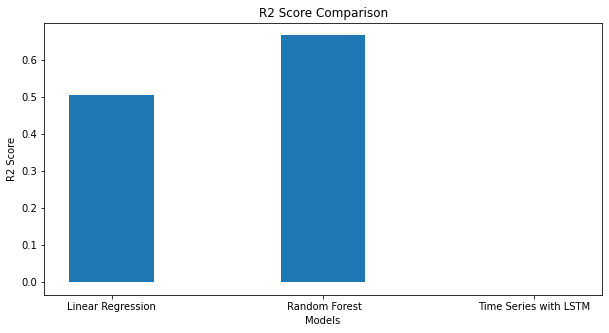

In [103]:
# For R squared
x = ["Linear Regression", " Random Forest", "Time Series with LSTM"]
y = [lin_reg.score(X_test,y_test), rfr.score(X_test,y_test), metrics.r2_score(y_test, model_y_preds)]

ig = plt.figure(figsize = (10, 5))
plt.bar(x, y, width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("R2 Score")
plt.title("R2 Score Comparison")
plt.show()

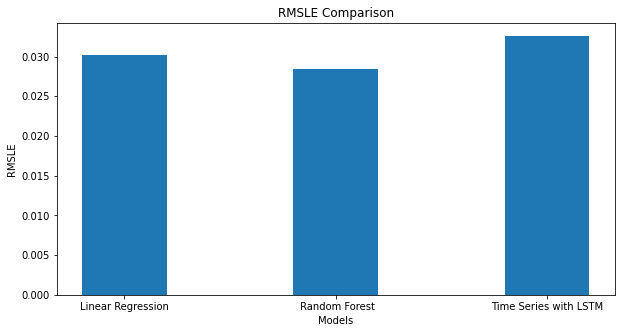

In [111]:
# For RMSLE
x = ["Linear Regression", " Random Forest", "Time Series with LSTM"]
y = [lin_reg_log_rmsle, rfr_rmsle , model_log_rmsle]

ig = plt.figure(figsize = (10, 5))
plt.bar(x, y, width = 0.4)
 
plt.xlabel("Models")
plt.ylabel("RMSLE")
plt.title("RMSLE Comparison")
plt.show()

# Other Models

## XGB regressor for Time Series Analysis

In [30]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

xgb = XGBRegressor()
#Create cross-validation
cv = TimeSeriesSplit(n_splits=5)
#Train & Test Model
cross_val_results = cross_val_score(xgb, X, y_log, cv=cv, scoring='neg_mean_squared_log_error')
print("RMSLE : ", cross_val_results.mean())


[12:43:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:43:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:43:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:43:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:44:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
-0.0007521722279723783


In [31]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

xgb = XGBRegressor()
#Create cross-validation
cv = TimeSeriesSplit(n_splits=5)
#Train & Test Model
cross_val_results = cross_val_score(xgb, X, y, cv=cv, scoring='r2')
print("R sqaured : ", cross_val_results.mean())

[12:44:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:44:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:44:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:44:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:45:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.655424709164574
